In [ ]:
# default_exp examples00

In [ ]:
#hide
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#hide
!pip install nbdev
!pip install fastcore

In [ ]:
#hide
% cd /content/drive/My\ Drive/fa_convnav

/content/drive/My Drive/fa_convnav


In [ ]:
#hide
#not deps but we need them to use nbdev and run tests
from nbdev import * 
from nbdev.showdoc import *
from fastcore.test import *

# Examples00

> How to use fa_convnav to view a CNN pretrained model.

To run this notebook, `!pip install fa_convnav` and then `from fa_convnav.examples00 import *` then run. The notebook will install fastai2 for you if it is not already installed.

In [ ]:
#hide
try:
  import fastai2.basics
except:
  !pip install fastai2
else:
  print('fastai2 already installed')

Import fastai deep learning library including pretrained vision models.

In [ ]:
from fastai2.basics import *
from fastai2.callback.all import *
from fastai2.vision.all import *
from torch import torch

Import the fa_convnav.navigator module

In [ ]:
from fa_convnav.navigator import *

Create a fastai datablock using the Oxford PetsII dataset (included with fastai install).

In [ ]:
pets = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                 get_items=get_image_files, 
                 splitter=RandomSplitter(),
                 get_y=RegexLabeller(pat = r'/([^/]+)_\d+.jpg$'),
                 item_tfms=Resize(460),
                 batch_tfms=[*aug_transforms(size=224, max_rotate=30, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])

Create a dataloader which enables data loading onto the GPU in batches for training, applying some simple image transforms in the process.

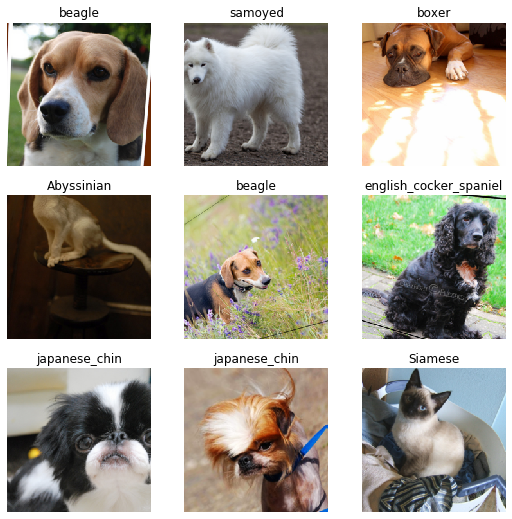

In [ ]:
dls = pets.dataloaders(untar_data(URLs.PETS)/"images",  bs=128)
dls.show_batch(max_n=9)

Download the pretarined model we want to use

In [ ]:
model = resnet18

Create a fastai Learner object from the dataloader, the chosen model, an optimiser and a metric to monitor training. With a Learner we can now train our model.

In [ ]:
learn = cnn_learner(
    dls, 
    model, 
    opt_func=partial(Adam, lr=slice(3e-3), wd=0.01, eps=1e-8), 
    metrics=error_rate, 
    config=cnn_config(ps=0.33)).to_fp16()

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 44.6MB/s]


We can also now use instantiate a ConvNav instance.

In [ ]:
cn = ConvNav(learn, learn.summary())

Creating an instance automatically builds a datraframe representation of the model (a CNDF dataframe). This step can take a few moments, especially for larger models such as densenets or xresnets which have hundreds of modules. If you have more than one Learner in your project, instantiate a separate ConvNav instance for each one. 

Once our dataframe is built we can view, search and select from it. For example, print some summary information:

In [ ]:
print(cn.model_info)

Resnet: Resnet18
Input shape: [128 x 3 x 224 x 224] (bs, ch, h, w)
Output features: [128 x 37] (bs, classes)
Currently frozen to parameter group 3 out of 3


Examine summary information about the body and head of the model.

In [ ]:
cn.divs

Resnet: Resnet18
Input shape: [128 x 3 x 224 x 224] (bs, ch, h, w)
Divisions:  body (0), head (1)



NameError: ignored

View the whole CNDF dataframe. Only the first ten modules are displayed here for brevity, but set `top = True` and all 79 rows (named_modules in the resnet18 model) will be shown. Run the notebook and try it!

In [ ]:
cn.view(top=True)

We can examine the layers of the head only. 

In [ ]:
cn.head

Or do interesting things like view just those layers with dimension change between input and outputs. 

In [ ]:
layers = cn.dim_transitions

When selections are made, the selected modules are shown in a dataframe (above) but the corresponding module objects are returned to the user in a list (below). Module objects can be used to apply Pytorch hooks and fastai callbacks to further investigate model function.

In [ ]:
layers